## Heart Disease Prediction

## Introduction:

**Background Information**
<br>
Heart diseases are a specific group of cardiovascular diseases that refer to conditions specifically affecting the behaviour or structure of the heart. These types of diseases are the leading cause of death across the world which explains why diagnosis at an early stage is important so that patients can get immediate treatment. Multiple underlying health conditions and lifestyle choices can increase the likelihood of heart diseases, such as diabetes, and high blood pressure. Some possible symptoms of heart disease are heart attacks, and strokes.

**Our Question:**
<br>
How accurately can we identify whether or not a patient has heart disease based on their age, resting blood pressure, and cholesterol level?

This dataset is a combination of 5 smaller datasets including the Cleveland, Hungarian, Switzerland, Stalog (Heart) Data Set, and Long Beach VA datasets all originally sourced from the UCI Machine Learning Repository. It contains information on health factors of patients and whether or not these patients had heart disease.


## Preliminary exploratory data analysis:

In [1]:
# import needed libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Reading and scaling the data

In [2]:
# read dataset from web
heart <- read_csv("https://raw.githubusercontent.com/josephsoo/dsci_100_group_12/main/data/heart.csv")


# clean and wrangle into tidy format
# by turning HeartDisease in a factor type and 
# removing rows where cholesterol = 0
heart <- mutate(heart, HeartDisease = as_factor(HeartDisease)) |> filter(Cholesterol != 0)
head(heart)

# for reference: 1 = has heart disease, 0 = does not have heart disease

# scale the dataset and select relevant variables
heart_scaled <- heart|>
    mutate(scaled_Cholesterol = scale(Cholesterol, center = TRUE),
        scaled_RestingBP = scale(RestingBP, center = TRUE),
        scaled_Age = scale(Age, center = TRUE))|>
    select(HeartDisease, scaled_Cholesterol, scaled_RestingBP, scaled_Age)

head(heart_scaled)

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


HeartDisease,scaled_Cholesterol,scaled_RestingBP,scaled_Age
<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0,0.7499910,0.4037096,-1.3551640
1,-1.0926718,1.5609328,-0.4083824
0,0.6485600,-0.1749020,-1.6707579
1,-0.5178963,0.2879873,-0.5135804
0,-0.8390944,0.9823212,0.1176074
0,1.5952492,-0.7535137,-1.4603620


## Splitting the data

In [3]:
set.seed(3456) 

# splitting data 75% = training, 25% = testing
heart_split <- initial_split(heart_scaled, prop = 0.75, strata = HeartDisease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

## Creating tables to summarize the training data

We have made tables showing the number of observations in each class and showing the mean of each predictor to analyze/summarize the data.

In [4]:
# number of observations in each class of heart disease
heart_disease_count <- heart_train |> group_by(HeartDisease) |> summarize(n = n())
heart_disease_count

# averages of each predictor variable
predictor_means <- heart_train |> select(-HeartDisease) |> map_df(mean)
colnames(predictor_means) <- c("scaled_Cholesterol_mean", "scaled_RestingBP_mean", "scaled_Age_mean")
predictor_means

HeartDisease,n
<fct>,<int>
0,292
1,267


scaled_Cholesterol_mean,scaled_RestingBP_mean,scaled_Age_mean
<dbl>,<dbl>,<dbl>
0.0008714988,0.02797431,0.03668586


## Creating data visualizations of the training data

We have made 3 scatter plots which show the distribution and relationship between all combinations of our predictor variables. The reason why we used only 2D visualizations is because 3D visualizations can be confusing to look at. These plots allow us to see if there are any general patterns in the data.

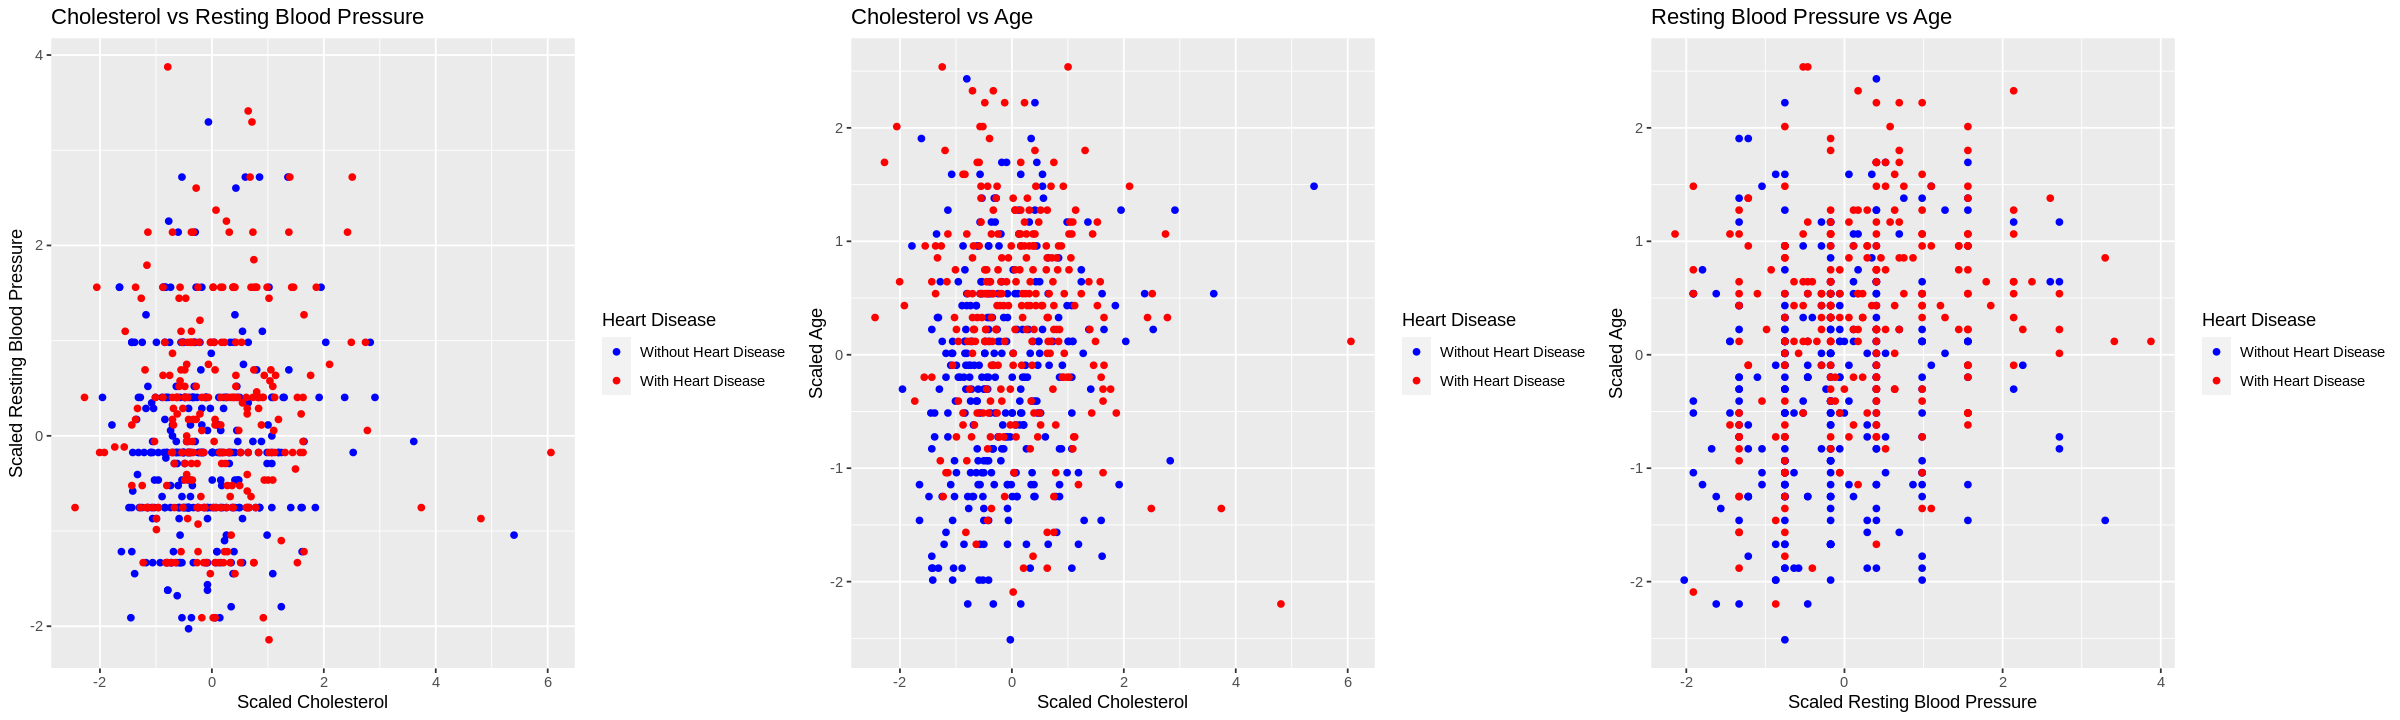

In [7]:
# Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do 
# (this is exploratory data analysis). An example of a useful visualization could be one that compares the 
# distributions of each of the predictor variables you plan to use in your analysis.
options(repr.plot.width = 20, repr.plot.height = 6)

cholesterol_resting_bp_plot <- heart_train |> ggplot(aes(x = scaled_Cholesterol, y = scaled_RestingBP, color = HeartDisease)) +
    geom_point() +
    labs(x = "Scaled Cholesterol", y = "Scaled Resting Blood Pressure", color = "Heart Disease", title = "Cholesterol vs Resting Blood Pressure")+
    scale_color_manual(labels = c("Without Heart Disease", "With Heart Disease"), , values = c("blue", "red"))

cholesterol_age_plot <- heart_train |> ggplot(aes(x = scaled_Cholesterol, y = scaled_Age, color = HeartDisease)) +
    geom_point() +
    labs(x = "Scaled Cholesterol", y = "Scaled Age", color = "Heart Disease", title = "Cholesterol vs Age")+
    scale_color_manual(labels = c("Without Heart Disease", "With Heart Disease"), , values = c("blue", "red"))

resting_bp_age_plot <- heart_train |> ggplot(aes(x = scaled_RestingBP, y = scaled_Age, color = HeartDisease)) +
    geom_point() +
    labs(x = "Scaled Resting Blood Pressure", y = "Scaled Age", color = "Heart Disease", title = "Resting Blood Pressure vs Age")+
    scale_color_manual(labels = c("Without Heart Disease", "With Heart Disease"), , values = c("blue", "red"))

grid.arrange(cholesterol_resting_bp_plot, cholesterol_age_plot, resting_bp_age_plot, ncol=3)

From looking at the plots, we can see that the chance of heart disease increases with age. No other relationships are immediately clear by eye, further analysis needed.

## Methods:

The 3 potential predictors:
- Age
- Cholesterol 
- Resting Blood Pressure

The variable we are predicting is:
- Heart Disease


**Method and Rationale**
<br>
Using all the variables in a data set is rarely a good idea in classification problems. 
Therefore, need to determine which subset of predictors offers the best performance. One way of doing so is to iteratively build up a model by adding predictors over each iteration, also known as forward selection.

After finding the subset of predictors which gives us the highest accuracy, we will create a classification model using that subset with the best k value. 

Ways we can visualize the results:
- line graph of accuracy vs number of predictors
- scatter plot with background color of predicted class

## Expected outcomes and significance:

**What do you expect to find?**
- In this project, we expect to be able to use the predictors Age, Cholestreol, and resting blood pressure to answer the question: Will someone have heart disease?

**What impact could such findings have?**

- By knowing if someone will have heart disease, we could be able to take note of people at risk and monitor them more closely. This might allow people who may be at risk for heart disease to recieve treatment before it's too late

**What future questions could this lead to?**

- If could we identify factors that make people more likely to get heart disease, could we then be able to change the lifestyle of the person to change the chance of them getting heart disease?

